In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

from gmphd_fusion.data import Track, StateVector, CovarianceMatrix, StateVectors
from gmphd_fusion.filter import KalmanFilter
from gmphd_fusion.generator import generate_trajectory, generate_paper_trajectories, generate_measurements, generate_clutter
from gmphd_fusion.gm import Gaussian, GaussianMixture
from gmphd_fusion.gmphd import GMPHD
from gmphd_fusion.measurement_model import LinearCoordinateMeasurementModel
from gmphd_fusion.motion_models import ConstantVelocityMotionModel
from gmphd_fusion.visualize import visualize_mixture, visualize_trajectories

In [3]:
surveillance_region = ((-1000, -1000), (1000, 1000))
xlim = ylim = (-1200, 1200)
surveillance_area = np.prod(np.diff(np.array(surveillance_region), axis=0))

clutter_rate = 50.0
clutter_spatial_density = clutter_rate / surveillance_area

detection_prob = 0.98
survival_prob = 0.99
prune_threshold = 1e-5
merge_threshold = 4
max_components = 1000

n_samples = 100

init_gm = GaussianMixture()
birth_mean_0 = StateVector([250, 250, 0, 0])
birth_mean_1 = StateVector([-250, -250, 0, 0])
birth_cov = CovarianceMatrix(np.diag([100, 100, 25, 25]))

birth_gm = GaussianMixture(
    gaussians=[
        Gaussian(mean=birth_mean_0, cov=birth_cov),
        Gaussian(mean=birth_mean_1, cov=birth_cov),
    ],
    weights=[0.1, 0.1],
)
kalman_filter = KalmanFilter()
motion_model = ConstantVelocityMotionModel(motion_noise=5)
measurement_model = LinearCoordinateMeasurementModel(dim_measurement=2, dim_state=4, measurement_noise=10)

In [4]:
gmphd = GMPHD(
    init_gm=init_gm,
    birth_gm=birth_gm,
    filter=kalman_filter,
    motion_model=motion_model,
    measurement_model=measurement_model,
    clutter_spatial_density=clutter_spatial_density,
    detection_prob=detection_prob,
    survival_prob=survival_prob,
    prune_threshold=prune_threshold,
    merge_threshold=merge_threshold,
    max_components=max_components,
)

In [5]:
# gt_obj_0 = StateVector([[-250], [-250], [0.5], [0.5]])
# gt_obj_1 = StateVector([[250], [250], [0], [0]])
# ground_truth = [
#     generate_trajectory(n_samples, motion_model, gt_obj_0),
#     generate_trajectory(n_samples, motion_model, gt_obj_1),
# ]
ground_truth = generate_paper_trajectories()
gt_track = [
    Track(0, start_time=0, estimates=[gt[:, i:i+1] for i in range(gt.shape[1])])
    for gt in ground_truth
]
measurements = [
    generate_measurements(gt, measurement_model)
    for gt in ground_truth
]
unif_min = np.array(surveillance_region).T[:, 0:1]
unif_max = np.array(surveillance_region).T[:, 1:2]
clutter = generate_clutter(n_samples, clutter_rate, unif_min, unif_max)

In [6]:
fake_track = Track(label=-1, start_time=1)

estimates = []

for time in range(n_samples):
    measurements_k = [m_obj[time] for m_obj in measurements if np.random.random() < detection_prob]
    clutter_k = clutter[time]
    meas_clut = StateVectors([*measurements_k, clutter_k])
    gmphd.step(meas_clut, timestamp=time + 1)
    est = gmphd.estimate_states()
    est_sv = StateVectors(np.hstack(list(est.values()))) if est else None
    estimates.append(est_sv)

tracks = gmphd.get_tracks()

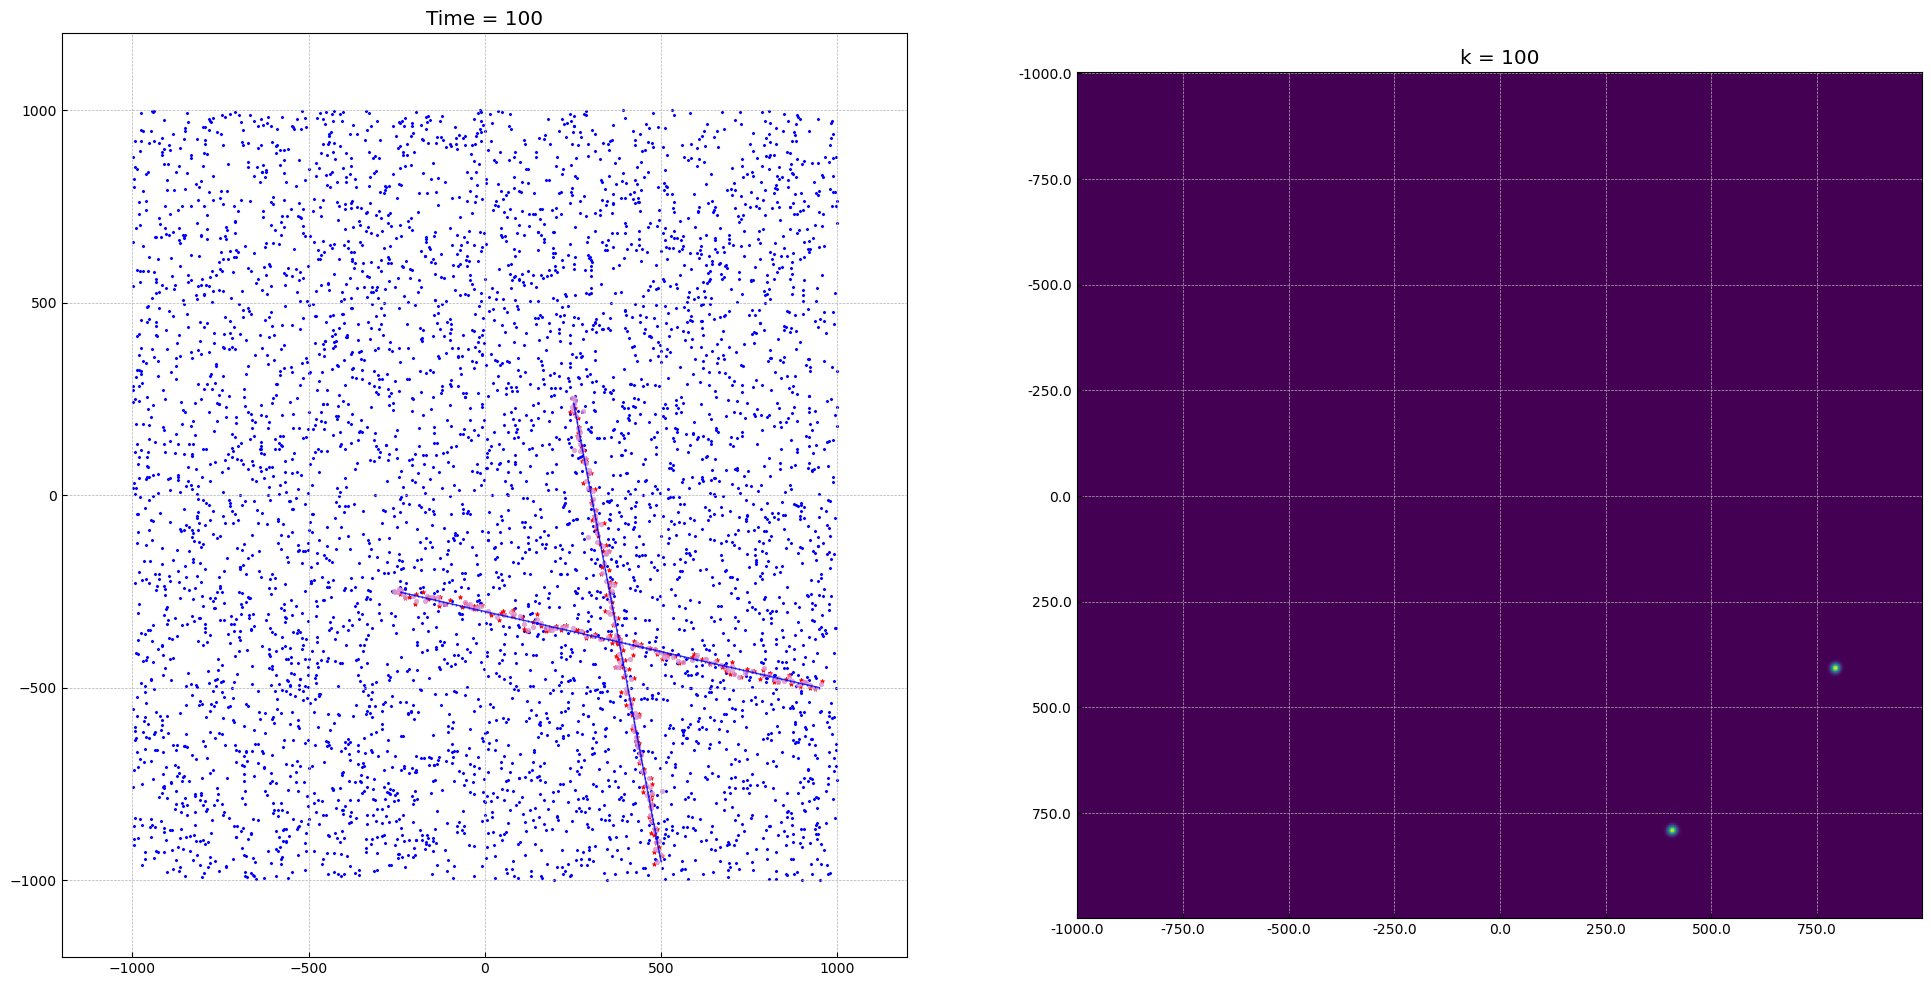

In [7]:
plt.style.use("bmh")
plt.rcParams.update({"figure.figsize" : (24, 12),
                     "axes.facecolor" : "white",
                     "axes.edgecolor":  "black"})

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_xlim(*xlim)
ax1.set_ylim(*ylim)
ax1.set_facecolor("white")

x_res = y_res = 500

ax2.set_xticks(np.linspace(0, x_res, num=9), np.linspace(surveillance_region[0][0], surveillance_region[1][0], num=9))
ax2.set_yticks(np.linspace(0, y_res, num=9), np.linspace(surveillance_region[0][1], surveillance_region[1][1], num=9))
# ax2.set_xlim(*xlim)
# ax2.set_ylim(*ylim)
# ax1.set_facecolor("white")

# cut = 0
# gt_cut = Track(label=gt_track.label, start_time=gt_track.start_time + cut, end_time=gt_track.end_time, estimates=gt_track.estimates[cut:])
# fake_cut = Track(label=fake_track.label, start_time=fake_track.start_time + cut, end_time=fake_track.end_time, estimates=fake_track.estimates[cut:])

visualize_trajectories(
    axis=ax1,
    ground_truth=gt_track,
    estimates=estimates,
    measurements=np.hstack(measurements),
    clutter=np.hstack(clutter),
    time=n_samples,
)
visualize_mixture(
    axis=ax2,
    mixture=gmphd.posterior,
    time=n_samples,
    xlim=xlim,
    ylim=ylim,
    x_res=x_res,
    y_res=y_res,
)
plt.show()